In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import deepxde as dde
import scipy as sp
import scipy.interpolate as interp
from deepxde.backend import tf
from matplotlib import pyplot as plt
from numpy.core.shape_base import hstack
exec(compile(open('param.py', "rb").read(), 'param.py', 'exec')) #% Roda arquivo com modelo BCS
def is_float(string):
    """ True if given string is float else False"""
    try:
        return float(string)
    except ValueError:
        return False
def ler_dados(str):
    with open(str, 'r') as f:
        d = f.readlines()
        epocas = np.zeros(len(d));
        tau = np.zeros(len(d));
        j = 0;
        data = []
        for i in d:
            k = i.rstrip().split(" ")
            data.append([float(i) if is_float(i) else i for i in k])
            epocas[j] = float(k[0])
            tau[j] = float(k[1])
            j += 1;
    return tau, epocas

def previsao(modelo,x,t):
    #Plota os três estados em função do tempo desnormalizados juntamente com
    # o valor previsto pela rede
    #modelo a ser recuperado. Requer compilação prévia
    #x = dados reais
    #t = tempo dos dados reais
    x=np.array(x)
    if isinstance(modelo, str):
        model.restore(modelo)
    yhat = model.predict(t)
    fig3=plt.figure()
    label = ['Pbh (bar)','Pwh (bar)','q(m3/s)'];
    for iu in range(0,3):
        ax3=fig3.add_subplot(3,1,iu+1)
        if iu==2:
            ax3.plot(tempo,(yhat[:,iu])*xc[2]*3600, '-b')
            ax3.plot(tempo,x[2,:]*xc[2]*3600, ':k')
            #ax3.plot([1,nsim],[umin[iu], umin[iu]],'--r')
            #ax3.plot([1,nsim],[umax[iu], umax[iu]],'--r', label='Restrição')
            ax3.set_ylabel(label[iu])
            #ax3.set(xlim=(xi[0], nsim*ts))
            # if iu==0:
            #     #ax2.set(ylim=(30, 70))
            #     print(iu)
            plt.grid(True)
        elif iu==0:
            ax3.plot(tempo,(yhat[:,iu])*xc[0]/1e5, '-b')
            ax3.plot(tempo,x[0,:]*xc[0]/1e5, ':k')
            #ax3.plot([1,nsim],[umin[iu], umin[iu]],'--r')
            #ax3.plot([1,nsim],[umax[iu], umax[iu]],'--r', label='Restrição')
            ax3.set_ylabel(label[iu])
            #ax3.set(xlim=(xi[0], nsim*ts))
            # if iu==0:
            #     #ax2.set(ylim=(30, 70))
            #     print(iu)
            plt.grid(True)
        else:
            ax3.plot(tempo,(yhat[:,iu])*xc[1]/1e5, '-b', label='predição')
            ax3.plot(tempo,x[1,:]*xc[1]/1e5, ':k', label='real')
            #ax3.plot([1,nsim],[umin[iu], umin[iu]],'--r')
            #ax3.plot([1,nsim],[umax[iu], umax[iu]],'--r', label='Restrição')
            ax3.set_ylabel(label[iu])
            #ax3.set(xlim=(xi[0], nsim*ts))
            # if iu==0:
            #     #ax2.set(ylim=(30, 70))
            #     print(iu)
            plt.grid(True)
            ax3.legend();
    plt.show()

# time points
maxtime = 10
time = np.linspace(0, maxtime, 200)

#pbh  pwh q - Pressão de fundo do poço,
#PI índice de produtividade do poço
#PinC  pressão na choke

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term
Dados carregados


In [2]:
fq_ss = 50
zc_ss = 50
pm_ss = 2e6# Pressão de manifold

uss = np.array([[fq_ss], [zc_ss], [pm_ss]])
u = uss
fqref = u[0]
zcref = u[1]
fq = fqref
zc = zcref
fq=60;zc=50;pm=2e6


def constante(valor,time_vector):
    return np.ones_like(time_vector)*valor

def aprbs(valor,time_vector):
    return np.ones_like(time_vector)*valor
# time points
maxtime = 200
time = np.linspace(0, maxtime, 200)
#entrada=constante(zc,time)# exogenous input



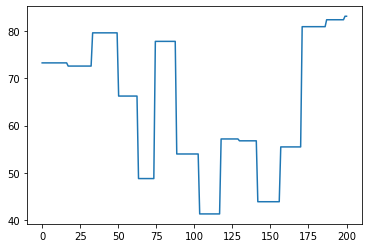

In [3]:


data = np.load('BCS_data_train_aprbs_zc.npz')
zc=data['zc']
entrada=zc

def ex_func(t):
    spline = sp.interpolate.Rbf(
        time, entrada, function="thin_plate", smooth=0, episilon=0
    )
    # return spline(t[:,0:])
    return spline(t)


F1c=941799.5331
F2c=2260318.8795
qcc=0.033987702
Hc=1511.97
tc=1/(PI*b1/V1)#tc=1
pbc=pr
qc=pbc*PI#;qc=1/30
pwc=tc*b2*qc/V2
xc=np.array([pbc,pwc,qc])

x1=data['x1']/xc[0]
x2=data['x2']/xc[1]
x3=data['x3']/xc[2]

tempo=data['t']/tc
rho=tf.Variable(940.0) #PI = 2.32e-9; # Well productivy index [m3/s/Pa]

plt.plot(time,ex_func(time))

In [4]:
def ED_BCS(t,x,ex):
    ## Montado o sistema de equa��es
    # Tensores (Estados)
    pbh = x[:,0:1]
    pwh = x[:,1:2]
    q = x[:,2:] #Vazão
    zc=ex #sinal exógeno


    # pbh=pbc*pbh
    # pwh=pwc*pwh
    # q=q*qc
    

    # Calculo do HEAD e delta de press�o
    q0 = qc*q / Cq * (f0 / fq)
    H0 = -1.2454e6 * q0 ** 2 + 7.4959e3 * q0 + 9.5970e2
    H = CH * H0 * (fq / f0) ** 2  # Head
    Pp = rho * g * H  # Delta de press�o

    # Calculo da Potencia e corrente da bomba
    P0 = -2.3599e9 * q0 ** 3 - 1.8082e7 * q0 ** 2 + 4.3346e6 * q0 + 9.4355e4
    P = Cp * P0 * (fq / f0) ** 3;  # Potencia
    I = Inp * P / Pnp  # Corrente

    # Calculo da press�o de intake
    F1 = 0.158 * ((rho * L1 * (qc*q) ** 2) / (D1 * A1 ** 2)) * (mu / (rho * D1 * (qc*q))) ** (1 / 4)
    F2 = 0.158 * ((rho * L2 * (qc*q) ** 2) / (D2 * A2 ** 2)) * (mu / (rho * D2 * (qc*q))) ** (1 / 4)
    pin = pbh*pbc - rho * g * h1 - F1;
    # Vazao do reservatorio e vazao na choke
    qr = PI * (pr - pbh*pbc);
    qch = Cc * (zc / 100) * tf.sign((pwh*pwc - pm)) * tf.sqrt(tf.abs(pwh*pwc - pm));
    
    qch=qch/qcc
    F1=F1/F1c
    H=H/Hc
    F2=F2/F2c

    # SEDO

    dpbhdt = dde.grad.jacobian(x, t, i=0)
    dpwhdt = dde.grad.jacobian(x, t, i=1)
    dqdt = dde.grad.jacobian(x, t, i=2)
   
    return [
        dpbhdt - (tc/pbc)*b1/V1*(qr - q*qc),
        dpwhdt - (tc/pwc)*b2/V2*(q*qc - qcc*qch),
        dqdt - (tc/(M*qc))*(pbh*pbc - pwh*pwc - rho*g*hw - F1c*F1 - F2c*F2 + rho * g * H*Hc)
        ]
    

In [5]:
def boundary(_, on_initial):
    return on_initial


xss = np.float32(np.array([8311024.82175957,2990109.06207437,0.00995042241351780]))
xssn = xss/xc
#print(xssn)


geom = dde.geometry.TimeDomain(0, 200/tc)
#geom = dde.geometry.TimeDomain(0, 1)

ic1 = dde.IC(geom, lambda v: xssn[0], boundary, component=0)
ic2 = dde.IC(geom, lambda v: xssn[1], boundary, component=1)
ic3 = dde.IC(geom, lambda v: xssn[2], boundary, component=2)

tempo=tempo.reshape(len(x1),1)
# print('x1.shape'+str(x1.shape))
# print('x2.shape'+str(x2.shape))
# print('x3.shape'+str(x3.shape))
# print('tempo.shape'+str(tempo.shape))
observe_x1 = dde.PointSetBC(tempo, x1, component=0)
observe_x2 = dde.PointSetBC(tempo, x2, component=1)
observe_x3 = dde.PointSetBC(tempo, x3, component=2)


In [6]:

# data = dde.data.PDE(
#     geom, ED_BCS, [ic1,ic2,ic3],# 35, 1,
#     #geom, ED_BCS, [ic1,ic2,ic3, observe_x1,observe_x2,observe_x3],# 35, 1,
#     #solution=func,
#     #num_test=5
#     num_domain=1,
#     num_boundary=1

#     )
data = dde.data.PDE(
    geom, ED_BCS, [ic1,ic2,ic3,observe_x1,observe_x2,observe_x3],# 35, 1,
    #solution=func,
    #num_test=0,
    num_domain=20,
    num_boundary=2,
    anchors=tempo,
    auxiliary_var_function=ex_func
    )
# data = dde.data.PDE(
#         geom, ED_BCS, [ic1,ic2,ic3,ic4,ic5], 35, 2,  num_test=100
#     )
layer_size = [1] + [30]*3 + [3]
activation = "tanh" # 
activation = "sigmoid"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)
#                   batch_normalization="before")
# callbacks for storing results
fnamevar = "rho.dat"
variable = dde.callbacks.VariableValue(rho, period=10, filename=fnamevar)
model = dde.Model(data, net)
checker = dde.callbacks.ModelCheckpoint("model/modelo3.ckpt", save_better_only=True)


In [7]:
#model.compile("L-BFGS-B")
model.compile("adam", lr=0.01)#, metrics=["l2 relative error"])
passos=2500
cb=[variable,checker]
cb=None
losshistory, train_state = model.train(epochs=passos,callbacks=cb)
# model.compile("L-BFGS-B")
# model.train(callbacks=cb)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.100399 s



/home/taniel/anaconda3/envs/BCS/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/taniel/anaconda3/envs/BCS/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.303388 s

Initializing variables...
Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.07e+00, 1.75e+00, 5.82e+01, 2.96e+00, 7.10e-02, 5.33e-01, 3.11e+00, 4.30e-02, 5.31e-01]    [1.07e+00, 1.75e+00, 5.82e+01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1000      [nan, nan, nan, nan, nan, nan, nan, nan, nan]                                                 [nan, nan, nan, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]                   []  


KeyboardInterrupt: 

Predicting...
'predict' took 0.479010 s



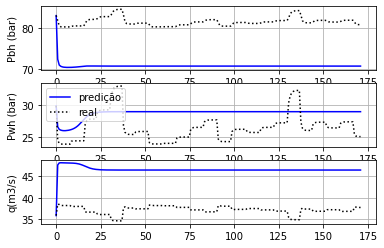

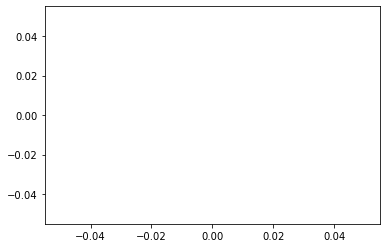

In [ ]:
modelo1="model/modelo3.ckpt-"+str(passos)
#modelo1="model/modelo3.ckpt-2000"
# model.compile("L-BFGS-B")
# model.train(callbacks=[variable,checker])
#print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
#previsao(modelo1,[x1,x2,x3],tempo)

previsao(2,[x1,x2,x3],tempo)

parametro,epocas=ler_dados("rho.dat")
#plt.plot(epocas,parametro)
plt.show()